### Random Model



In [2]:
import argparse
import sys
import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import wrappers, logger


EPISODES = 500
ALL_SCORES = np.zeros(EPISODES)

env = gym.make("MsPacman-ram-v0")
env = wrappers.Monitor(env, '/tmp/MsPacman-ram-experiment-1',force=True)

for episode in range(EPISODES):
    env.reset()
    
    reward, info, done = None, None, None

    
    total_score = 0
    while done != True:
        env.render()
        random_action = env.action_space.sample()
        state, reward, done, info = env.step(random_action)
        total_score += reward
    ALL_SCORES[episode] = total_score
    print("Total Score: {}".format(total_score))
    # print(state, reward, done, info)
    
env.close()
plt.plot(ALL_SCORES)
plt.title("Random Agent: {} Episodes".format(EPISODES))
plt.show()

print("-------------------------")
print('Average Score for {} Episodes: {}'.format(EPISODES, np.mean(ALL_SCORES)))


Total Score: 240.0
Total Score: 230.0
Total Score: 150.0
Total Score: 210.0
Total Score: 340.0
Total Score: 220.0
Total Score: 140.0
Total Score: 240.0
Total Score: 180.0
Total Score: 200.0
Total Score: 130.0
Total Score: 230.0
Total Score: 190.0
Total Score: 150.0
Total Score: 250.0
Total Score: 210.0
Total Score: 280.0
Total Score: 250.0
Total Score: 1010.0
Total Score: 110.0
Total Score: 180.0
Total Score: 200.0
Total Score: 220.0
Total Score: 160.0
Total Score: 270.0
Total Score: 280.0
Total Score: 140.0
Total Score: 260.0
Total Score: 210.0
Total Score: 130.0
Total Score: 180.0
Total Score: 210.0
Total Score: 150.0
Total Score: 150.0
Total Score: 220.0
Total Score: 190.0
Total Score: 390.0
Total Score: 110.0
Total Score: 270.0
Total Score: 240.0
Total Score: 200.0
Total Score: 330.0
Total Score: 190.0
Total Score: 320.0
Total Score: 280.0
Total Score: 190.0
Total Score: 210.0
Total Score: 200.0
Total Score: 130.0
Total Score: 230.0
Total Score: 170.0
Total Score: 350.0
Total Score

KeyboardInterrupt: 

v2- corrected reward (0.01 LR, batch size 256, min epsilon 0.05, episilon decay 0.9999)  
v2- corrected reward (0.05 LR, batch size 256, min epsilon 0.0, episilon decay 0.99999), increased memeory from 2000 to 10000

BOTH STILL GET STUCK

## Training Model

In [ ]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from gym import wrappers


# DQN Agent for the MsPacman
# it uses Neural Network to approximate q function and replay memory & target q network
class DQNAgent:
    def __init__(self, state_size, action_size):
        # if you want to see MsPacman learning, then change to True
        self.render = True
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.005
        self.epsilon = 1.0
        self.epsilon_decay = 0.99999
        self.epsilon_min = 0.0
        self.batch_size = 64
        self.train_start = 1000
        
        # create replay memory using deque
        self.memory = deque(maxlen=1000000)

        # create main model
        self.model = self.build_model()

        if self.load_model:
            self.model.load_weights("./Saved Weights/pacman.h5")

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # pick samples randomly from replay memory (with batch_size)
    def train_model(self):

        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
#         total_training_steps += batch_size

        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0] #STATE
            action.append(mini_batch[i][1])    #ACTION
            reward.append(mini_batch[i][2])    #REWARD
            update_target[i] = mini_batch[i][3]#NEXT STATE
            done.append(mini_batch[i][4])      #DONE

        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)


        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * (np.amax(target_val[i]))
#                 print(np.amax(target_val[i]))
#         print(update_input, update_target)

        # and do the model fit!
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
        


if __name__ == "__main__":
    EPISODES = 1000
    env = gym.make('MsPacman-ram-v0')
    env = wrappers.Monitor(env, '/tmp/MsPacman-ram-experiment-1',force=True)
    
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])/256.0
#         print(state)
        lives = 3
        while not done: 
            dead = False         
            while not dead:
                if agent.render:
                    env.render()

                # get action for the current state and go one step in environment
                action = agent.get_action(state)
                next_state, reward, done, info = env.step(action)
                score += reward
                
                dead = info['ale.lives'] != lives
                lives = info['ale.lives']
#                 if (dead):
#                     print(dead, done)
                reward = reward - 2 if not dead else -10000  # if action make Pacman dead, then gives penalty of -100
#                 print(reward)
                next_state = np.reshape(next_state, [1, state_size])/256.0
                
               
                
                
                # save the sample <s, a, r, s'> to the replay memory
                agent.append_sample(state, action, reward, next_state, done)
                
                # every time step do the training
                agent.train_model()
                
                state = next_state            
                
                
                


            if done:
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./pacman.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)
#     #   # save the model
        if e % 10 == 0:
            agent.model.save_weights("./Saved Weights/pacman_correctedv22.h5")

#     print("Total Training Steps: {}".format(total_training_steps))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 1161      
Total params: 50,697
Trainable params: 50,697
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: 240.0   memory length: 642   epsilon: 0.9936005322743837
episode: 1   score: 210.0   memory length: 1377   epsilon: 0.9863243048735006
episode: 2   score: 220.0   memory length: 2015   epsilon: 0.9800515557916739
episode: 3   score: 290.0   memory le

episode: 93   score: 270.0   memory length: 61504   epsilon: 0.5406176075866189
episode: 94   score: 270.0   memory length: 62024   epsilon: 0.5378136785412454
episode: 95   score: 330.0   memory length: 62564   epsilon: 0.534917297462358
episode: 96   score: 280.0   memory length: 63192   epsilon: 0.5315685262379667
episode: 97   score: 270.0   memory length: 63724   epsilon: 0.5287480766242494
episode: 98   score: 1000.0   memory length: 64890   epsilon: 0.5226186474202748
episode: 99   score: 190.0   memory length: 65488   epsilon: 0.51950269830248
episode: 100   score: 210.0   memory length: 65991   epsilon: 0.5168961476678009
episode: 101   score: 380.0   memory length: 66652   epsilon: 0.5134907144605512
episode: 102   score: 260.0   memory length: 67265   epsilon: 0.5103526287498422
episode: 103   score: 290.0   memory length: 67889   epsilon: 0.5071779278410745
episode: 104   score: 230.0   memory length: 68437   epsilon: 0.5044061804619976
episode: 105   score: 380.0   memory 

episode: 194   score: 920.0   memory length: 134276   epsilon: 0.2611222177976033
episode: 195   score: 180.0   memory length: 134673   epsilon: 0.2600876124703567
episode: 196   score: 1890.0   memory length: 135607   epsilon: 0.257669691349366
episode: 197   score: 550.0   memory length: 136426   epsilon: 0.2555679843069159
episode: 198   score: 570.0   memory length: 137188   epsilon: 0.25362794749385814
episode: 199   score: 1090.0   memory length: 138184   epsilon: 0.25111433911804726
episode: 200   score: 380.0   memory length: 138948   epsilon: 0.24920312614111714
episode: 201   score: 400.0   memory length: 139594   epsilon: 0.24759845459246715
episode: 202   score: 350.0   memory length: 140116   epsilon: 0.2463093516997044
episode: 203   score: 310.0   memory length: 140759   epsilon: 0.2447306556219549
episode: 204   score: 410.0   memory length: 141491   epsilon: 0.24294575898993873
episode: 205   score: 350.0   memory length: 142154   epsilon: 0.24134034839765459
episode: 

### FINDING

The Pacman learns to just stay in the corner after consuming the "Power Pellets" since the reward from consuming ghosts outweight the negative reward of dying. Must increase the negative reward from dying.

The learned weights will be in 'correctedv1.h5'

# Code to Test Trained Weights- No Training Involved

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_28 (Dense)             (None, 9)                 1161      
Total params: 50,697
Trainable params: 50,697
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: 240.0
episode: 1   score: 240.0
episode: 2   score: 250.0
episode: 3   score: 850.0
episode: 4   score: 840.0
episode: 5   score: 250.0
episode: 6   score: 920.0
episode: 7   score: 500.0
episode: 8   score: 320.0
episode: 9   score: 240.0
episode: 1

KeyboardInterrupt: 

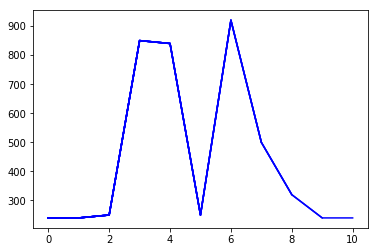

In [7]:
# DQN Agent for the MsPacman
# it uses Neural Network to approximate q function and replay memory & target q network
class TEST_DQNAgent:
    def __init__(self, state_size, action_size):
        # if you want to see MsPacman learning, then change to True
        self.render = True
        self.load_model = True
        self.epsilon = 0.1

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        
        # create main model
        self.model = self.build_model()

        if self.load_model:
            self.model.load_weights("./Saved Weights/pacman_correctedv15.h5")

    # approximate Q function using Neural Network
    # state is input and Q Value of each action is output of network
    def build_model(self):
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation=None, kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam())
        return model

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])
#         q_value = self.model.predict(state)
#         return np.argmax(q_value[0])
        
        
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from gym import wrappers
import matplotlib.pyplot as plt


if __name__ == "__main__":
    EPISODES = 100
    ALL_SCORES = np.zeros(EPISODES)

    env = gym.make('MsPacman-ram-v0')
    env = wrappers.Monitor(env, '/tmp/MsPacman-ram-experiment-1',force=True)
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = TEST_DQNAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        lives = 3
        while not done: 
            dead = False         
            while not dead:
                if agent.render:
                    env.render()

                # get action for the current state and go one step in environment
                action = agent.get_action(state)
                next_state, reward, done, info = env.step(action)
                next_state = np.reshape(next_state, [1, state_size])

                state = next_state            
                score += reward
                dead = info['ale.lives']<lives
                lives = info['ale.lives']
                # if an action make the Pacman dead, then gives penalty of -100
                reward = reward if not dead else -500

            if done:
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./pacman.png")
                print("episode:", e, "  score:", score)
        
        ALL_SCORES[e] = score
                
    env.close()
    plt.plot(ALL_SCORES)
    plt.title("Random Agent: {} Episodes".format(EPISODES))
    plt.show()

    print("-------------------------")
    print('Average Score for {} Episodes: {}'.format(EPISODES, np.mean(ALL_SCORES)))